In [1]:
library(ggplot2)
library(dplyr)
library(glue)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [8]:
output = read.table("~/Desktop/output.txt",header=TRUE)
output = output %>% distinct()
output[is.na(output$flag),]$flag = "7_cts"
state_type = unique(output$state_type)
num_cells = unique(output$flag)
head(output)
dim(output)

,seed,method,state_type,dim,total_cells,perc_genes,perc_cells,flag,ct_in_state,adj.rsq,max.rsq,max.rsq_sub,total_cells_can_occupy_state,total_cells_occupy_state,total_genes,total_genes_in_state
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,5,PCA,within_one_ct,10,20000,0.15,0.3,7_cts,EX,0.2217110,0.10375358,0.049929683,2001,600,2527,379
2,8,PCA,within_one_ct,10,20000,0.15,0.3,7_cts,MG,0.2379077,0.12935458,0.006875595,1292,387,2527,379
3,6,PCA,within_one_ct,10,20000,0.15,0.3,7_cts,ODC,0.1123940,0.08348754,0.002228151,12220,3666,2527,379
4,6,PCA,within_one_ct,10,20000,0.15,0.7,7_cts,ODC,0.3491209,0.25840651,0.005449603,12220,8554,2527,379
5,2,PCA,within_one_ct,10,20000,0.15,0.5,7_cts,ODC,0.2161818,0.16002318,0.002795771,12220,6110,2527,379
6,9,PCA,within_one_ct,10,20000,0.15,0.7,7_cts,INH,0.5483137,0.28332267,0.012073433,1939,1357,2527,379


[1] 2341   16

In [4]:
tmp_df <- na.omit(output)

sd = tmp_df %>% group_by(method,state_type,dim, total_cells, flag, perc_genes, perc_cells) %>% 
                      summarise(across(c(adj.rsq,max.rsq,max.rsq_sub),sd),
                    .groups = 'drop') %>%
                      as.data.frame()


counts = tmp_df %>% group_by(method,state_type,dim, total_cells, flag, perc_genes, perc_cells) %>% 
                      summarise(n = n())%>%
                      as.data.frame()

colnames(sd)[(length(colnames(sd))-2) : length(colnames(sd)) ] = paste0("sd","_", colnames(sd)[(length(colnames(sd))-2) : length(colnames(sd)) ] )


mean = tmp_df %>% group_by(method,state_type,dim, total_cells, flag, perc_genes, perc_cells) %>% 
                      summarise(across(c(adj.rsq,max.rsq,max.rsq_sub),mean),
                    .groups = 'drop') %>%
                      as.data.frame()

all_merged = merge(mean, merge(sd,counts,by=colnames(sd)[1:7]), by=colnames(sd)[1:7] )
all_merged$conf_int_max.rsq_sub = all_merged$sd_max.rsq_sub / sqrt(all_merged$n) * qnorm(0.975)
all_merged$perc_genes_perc_cells = paste(all_merged$perc_genes, all_merged$perc_cells, sep=", ")

`summarise()` has grouped output by 'method', 'state_type', 'dim',
'total_cells', 'flag', 'perc_genes'. You can override using the `.groups`
argument.


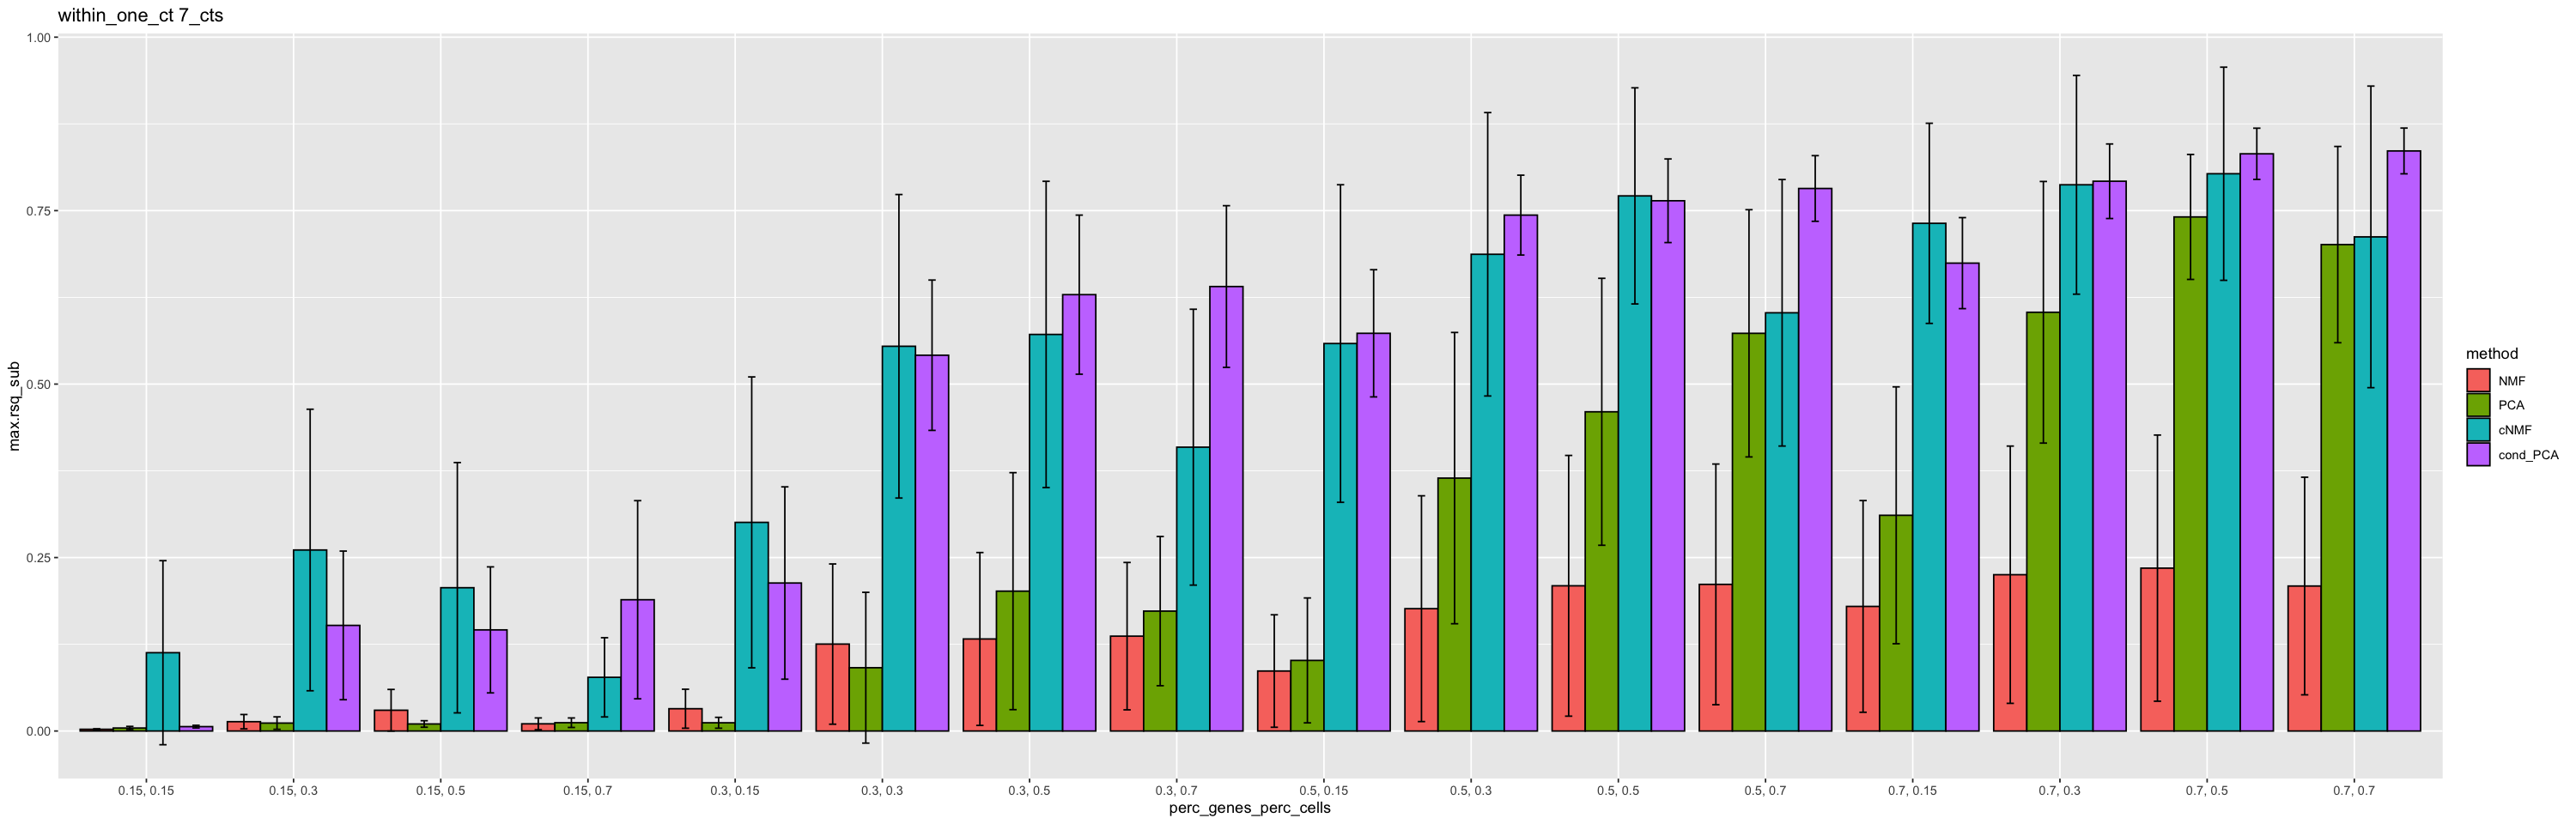

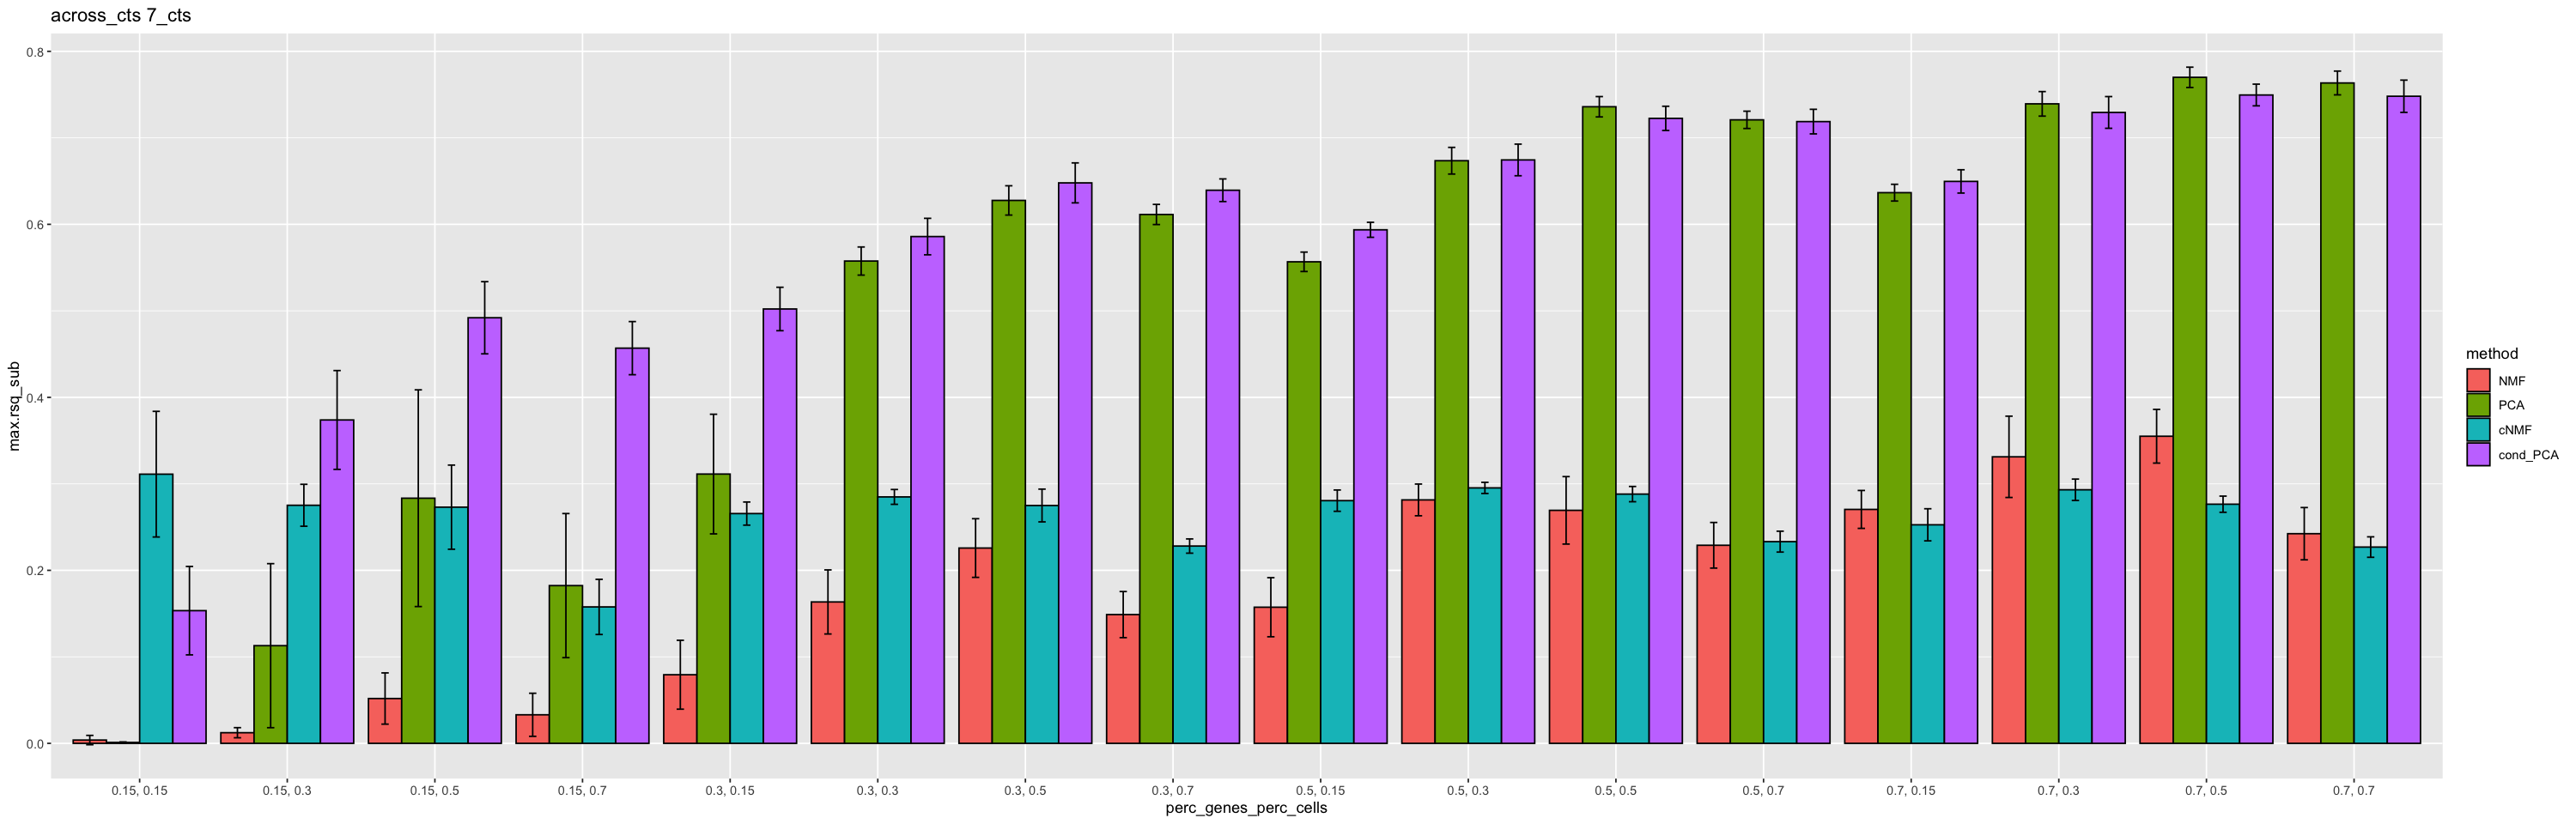

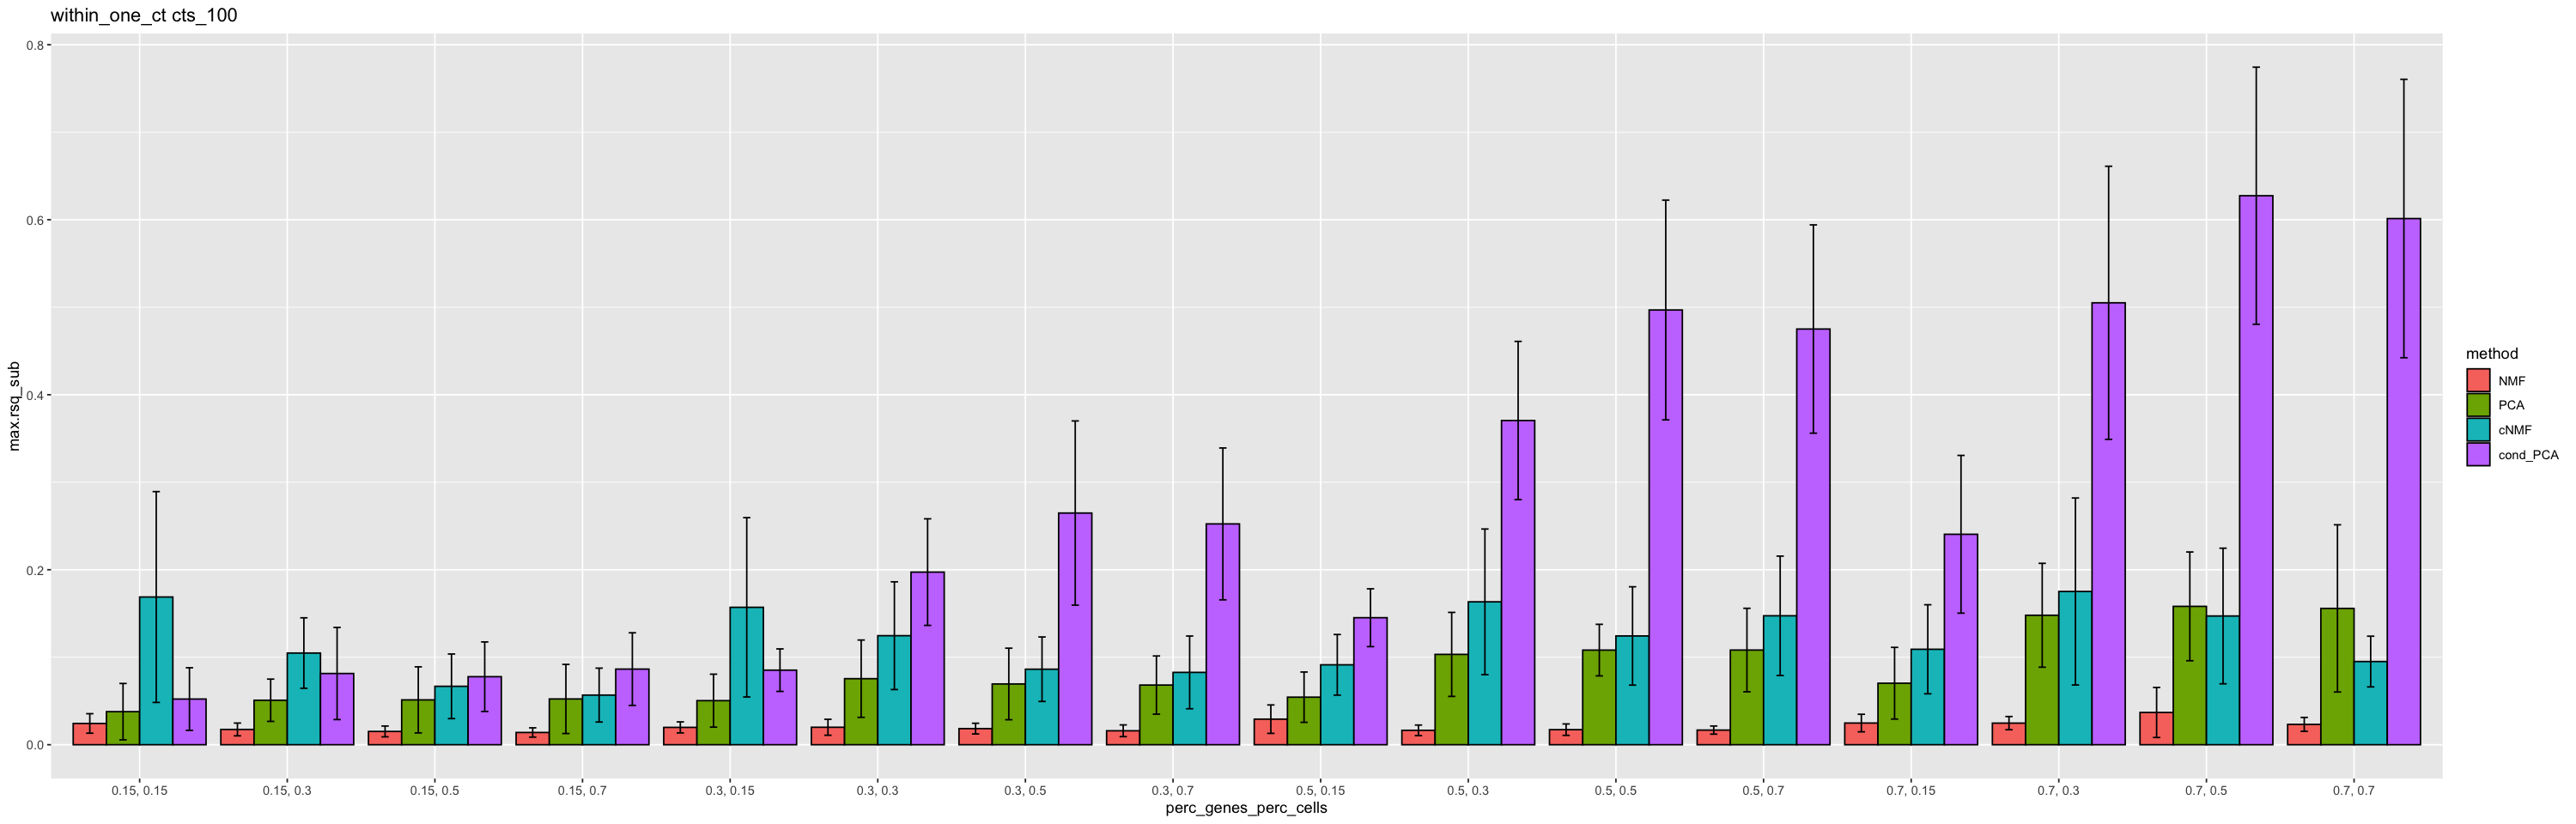

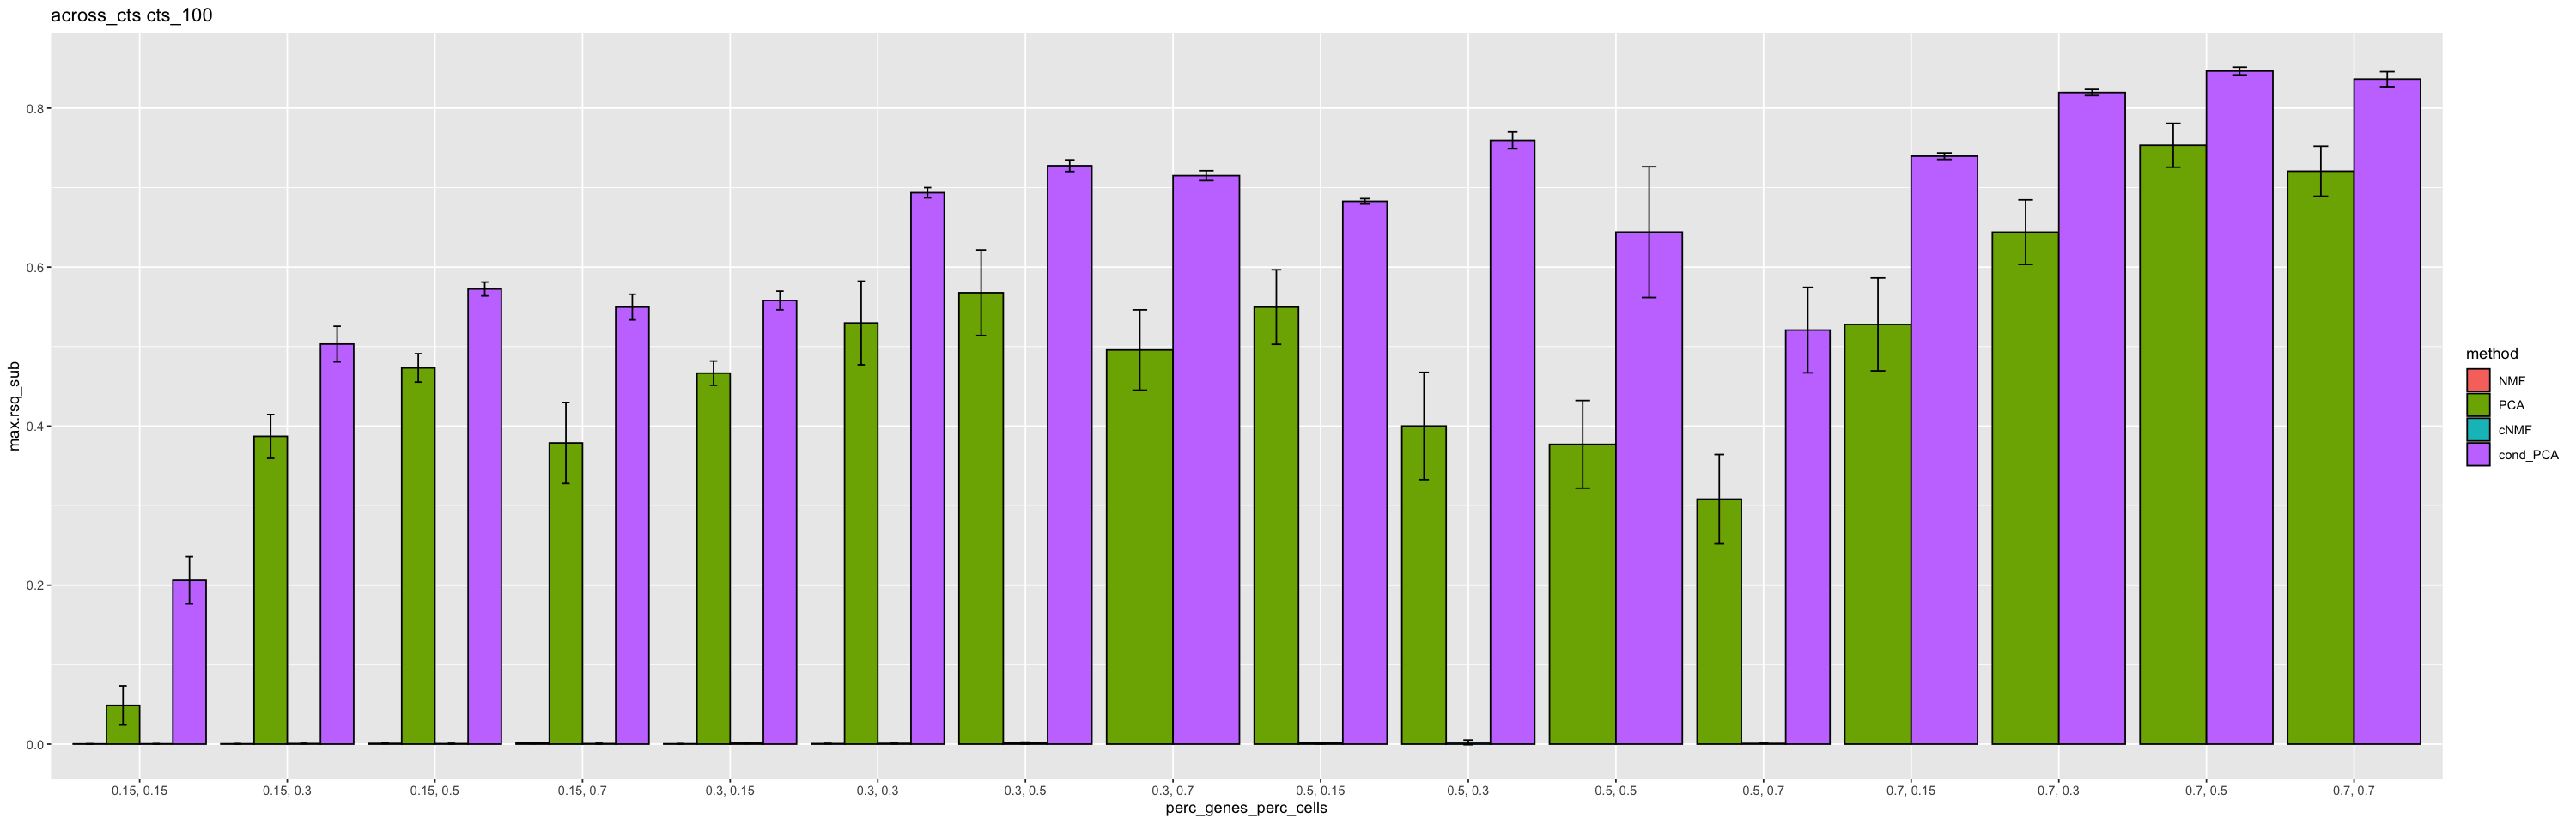

In [9]:
options(repr.plot.width=10, repr.plot.height=8)

num_cells = c("7_cts","cts_100")

for (num_cells_ in num_cells){
    for (state_type_ in state_type){
    
        options(repr.plot.width=25, repr.plot.height=8)
        #all_merged
        
        tmp_df = all_merged[all_merged$state_type == state_type_ & all_merged$flag == num_cells_,]

        # plot where perc genes equals perc cells
        p = ggplot(data=tmp_df, aes(x=perc_genes_perc_cells, y=max.rsq_sub, fill=method)) +
         geom_bar(stat="identity", color="black", position=position_dodge()) +
  geom_errorbar(aes(ymin=max.rsq_sub-conf_int_max.rsq_sub, ymax=max.rsq_sub+conf_int_max.rsq_sub), width=.2,
                 position=position_dodge(.9)) + ggtitle(glue("{state_type_} {num_cells_}"))
        print(p)
    }
    
}